<a href="https://colab.research.google.com/github/Asadsammar/ML_LabWork1_W10/blob/main/LabWork1_W10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Construct a tf.data.Dataset
ds = tfds.load('mnist', split='train', shuffle_files=True)

# Build your input pipeline
ds = ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
for example in ds.take(1):
  image, label = example["image"], example["label"]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Once in a while, a movie will sweep along that stuns you, draws you in, awes you, and, in the end, leaves you with a renewed belief in the human race from the artistry form. This is not it. This is an action movie that lacks convincing action. It stinks. Rent something else.'
 b"This movie is good for what it is, and unpretentious; I wouldn't watch it twice, however: I am a Peter Cushing completist and that's why I watched it. The best asset of this movie is: BREVITY and EFFECTIVENESS. Compared to other similar movies, it does NOT drag its feet forever as each of the four (plus one) segments lasts under 30 minutes, with the last under 10. Good uncanny vibes. In the first segment, horror writer suffering from 'writer's block' relocates to secluded old house seeking inspiration. He finds even too much of it when he starts to visualize one of his fictional madmen. Plot contrivance similar to PREMATURE BURIAL. Good use of the point-of-view twist: is the writer getting mentally i

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[272,   8,   4, ...,   0,   0,   0],
       [ 11,  18,   7, ...,   0,   0,   0],
       [ 10, 103,   2, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Once in a while, a movie will sweep along that stuns you, draws you in, awes you, and, in the end, leaves you with a renewed belief in the human race from the artistry form. This is not it. This is an action movie that lacks convincing action. It stinks. Rent something else.'
Round-trip:  once in a while a movie will [UNK] along that [UNK] you [UNK] you in [UNK] you and in the end leaves you with a [UNK] [UNK] in the human [UNK] from the [UNK] form this is not it this is an action movie that [UNK] [UNK] action it [UNK] rent something else                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-0.01357703]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 239ms/step
[-0.01357703]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 361s 905ms/step - loss: 0.6359 - accuracy: 0.5871 - val_loss: 0.4760 - val_accuracy: 0.7859
Epoch 2/10
391/391 [==============================] - 341s 873ms/step - loss: 0.4001 - accuracy: 0.8192 - val_loss: 0.3647 - val_accuracy: 0.8333
Epoch 3/10
391/391 [==============================] - 350s 895ms/step - loss: 0.3364 - accuracy: 0.8520 - val_loss: 0.3364 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 352s 901ms/step - loss: 0.3217 - accuracy: 0.8605 - val_loss: 0.3279 - val_accuracy: 0.8521
Epoch 5/10
391/391 [==============================] - 347s 888ms/step - loss: 0.3120 - accuracy: 0.8674 - val_loss: 0.3257 - val_accuracy: 0.8516
Epoch 6/10
391/391 [==============================] - 347s 887ms/step - loss: 0.3087 - accuracy: 0.8677 - val_loss: 0.3284 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 347s 888ms/step - loss: 0.3048 - accuracy: 0.8693 - val_loss: 0.3249 -

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 89s 227ms/step - loss: 0.3188 - accuracy: 0.8615
Test Loss: 0.3188221752643585
Test Accuracy: 0.8614799976348877


(0.0, 0.6527136996388435)

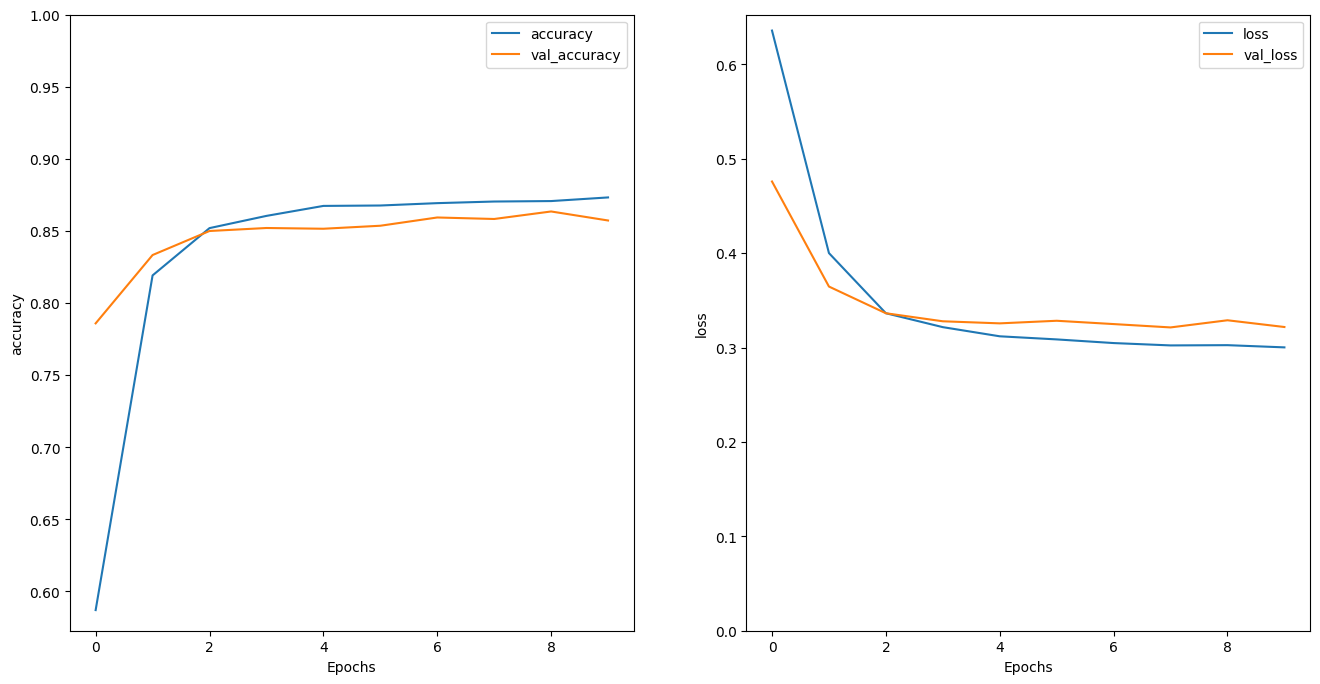

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 707s 2s/step - loss: 0.6206 - accuracy: 0.5878 - val_loss: 0.4343 - val_accuracy: 0.7922
Epoch 2/10
391/391 [==============================] - 672s 2s/step - loss: 0.3792 - accuracy: 0.8320 - val_loss: 0.3503 - val_accuracy: 0.8479
Epoch 3/10
391/391 [==============================] - 665s 2s/step - loss: 0.3320 - accuracy: 0.8572 - val_loss: 0.3293 - val_accuracy: 0.8568
Epoch 4/10
391/391 [==============================] - 667s 2s/step - loss: 0.3187 - accuracy: 0.8630 - val_loss: 0.3278 - val_accuracy: 0.8625
Epoch 5/10
391/391 [==============================] - 665s 2s/step - loss: 0.3122 - accuracy: 0.8660 - val_loss: 0.3475 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 671s 2s/step - loss: 0.3071 - accuracy: 0.8676 - val_loss: 0.3266 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 672s 2s/step - loss: 0.3031 - accuracy: 0.8700 - val_loss: 0.3199 - val_accuracy: 0.8615

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 160s 408ms/step - loss: 0.3231 - accuracy: 0.8636
Test Loss: 0.32312047481536865
Test Accuracy: 0.8636400103569031


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.8284444]]


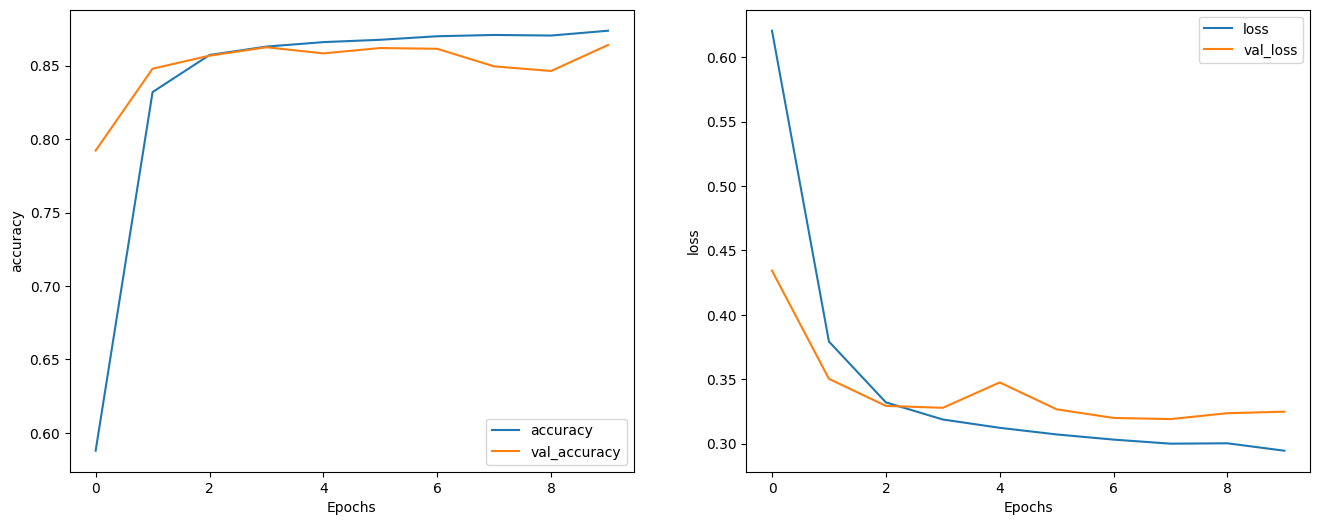

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')